<a href="https://colab.research.google.com/github/Ankita-chouhan-github/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_(Capstone_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**NYC Taxi Trip Price Prediction : Predicting total ride duration of taxi trips in New York City**

**Business Context**

your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers and several other variables.

In [2]:
# Importing the Libraries
import numpy as np
import pandas as pd
from numpy import math
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt

!pip install shap==0.40.0
import shap 
import graphviz
sns.set_style('darkgrid') 

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.6/567.6 kB 29.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Data Import from CSV file to pandas dataframe
NYC_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Regression Capstone Project/NYC Taxi Data.csv')

**Exploratory Data Analysis**

Exploring data to understand what it contains and in which format and how much transformation we need to do to derive meanigful conclusions and predictions from the given data

In [6]:
NYC_df.shape

(1458644, 11)

In [9]:
NYC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


There are no null values in the data. 

In [20]:
NYC_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

### **Feature details:**


* id - a unique identifier for each trip

* vendor_id - a code indicating the provider associated with the trip record

* pickup_datetime - date and time when the meter was engaged

* dropoff_datetime - date and time when the meter was disengaged

* passenger_count - the number of passengers in the vehicle (driver entered value)

* pickup_longitude - the longitude where the meter was engaged

* pickup_latitude - the latitude where the meter was engaged

* dropoff_longitude - the longitude where the meter was disengaged

* dropoff_latitude - the latitude where the meter was disengaged

* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

* Categorizing the features :

**Let's divide features into categories:**

* Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

* Time related: pickup_datetime, dropoff_datetime

* Identifier: id(not useful for analysis)

* Others: vendor_id, passenger_count, store_and_fwd_flag



In [32]:
NYC_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [21]:
NYC_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [22]:
NYC_df.shape

(1458644, 11)

In [23]:
NYC_df.drop_duplicates(inplace=True)
NYC_df.shape

(1458644, 11)

* NO duplicates Values were found in the dataset
* There are approximately 1.5 ,illion rows in our data and 11 rows.
* There are no null values in our data.


In [24]:
NYC_df['trip_duration'].isnull().sum()

0

In [40]:
NYC_df['passenger_count'].value_counts().reset_index().sort_values(by='index')

,index,passenger_count
6,0,60
0,1,1033540
1,2,210318
3,3,59896
5,4,28404
2,5,78088
4,6,48333
7,7,3
9,8,1
8,9,1


* There are 60 rides in which there are 0 passengers so we create a new dataframe which contains only rows with atleast 1 passenger.

In [41]:
NYC_df = NYC_df[NYC_df['passenger_count']!=0]

In [42]:
NYC_df['passenger_count'].value_counts().reset_index().sort_values(by='index')

,index,passenger_count
0,1,1033540
1,2,210318
3,3,59896
5,4,28404
2,5,78088
4,6,48333
6,7,3
8,8,1
7,9,1


In [43]:
NYC_df['pickup_datetime'][0]

'2016-03-14 17:24:55'

In [45]:
# Converting time stamp to date time format to fetch other details from it
NYC_df['pickup_datetime']=pd.to_datetime(NYC_df['pickup_datetime'])
NYC_df['dropoff_datetime']=pd.to_datetime(NYC_df['dropoff_datetime'])
NYC_df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


[Text(0.5, 1.0, 'Distribution Plot for Trip Duration')]

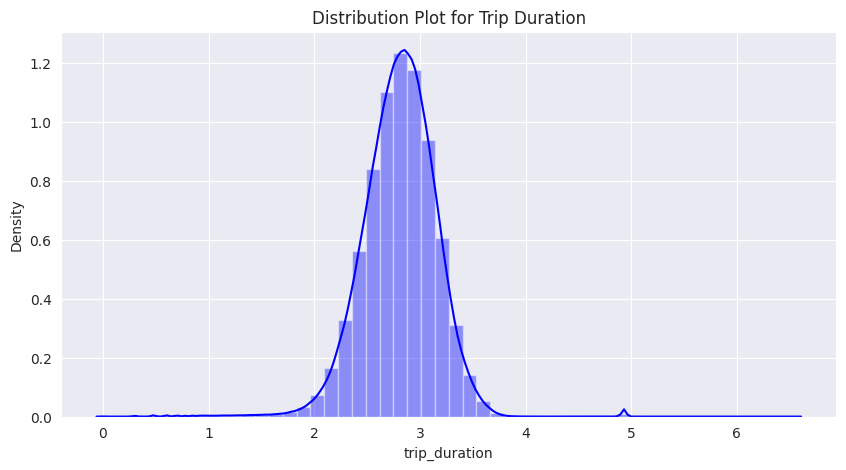

In [52]:
# Dependent variable is 'trip_duration'
plt.figure(figsize=(10,5))
sns.distplot(np.log10(NYC_df['trip_duration']), color='b').set(title='Distribution Plot for Trip Duration')

* We can see it is a normally distributed plot